## Fourier Neural Operator

Add some description

paper: https://arxiv.org/abs/2010.08895

In [1]:
# external imports
import torch
from torch.utils.data import DataLoader
from torch.distributions.multivariate_normal import MultivariateNormal
import matplotlib.pyplot as plt

# continuity imports
from continuity.trainer import Trainer
from continuity.data import OperatorDataset
from continuity.operators.fourier_neural_operator import FourierLayer

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

## 1D Dataset

In [3]:
# Input function
u = lambda chi: torch.cos(chi)
u = lambda chi: torch.exp(-chi**2)*10

# Target function
v = lambda chi: torch.sin(chi)
v = lambda chi: torch.exp(-chi**2)*2*10 * (-chi)

# Domain parameters
L = torch.pi * 2
N = 1000
xi = torch.arange(-N/2, N/2) / N * L  # from the same domain as y and x to plot "continuous" representations of u and v

num_sensors = 31
num_evaluations = 31
x = (torch.arange(-num_sensors/2, num_sensors/2) / num_sensors * L ).to(device)
y = (torch.arange(-num_evaluations/2, num_evaluations/2) / num_evaluations * L).to(device)

# This dataset contains only a single sample (first dimension of all tensors)
n_observations = 1
u_dim = x_dim = y_dim = v_dim = 1
dataset = OperatorDataset(
    x=x.reshape(n_observations, num_sensors, x_dim),
    u=u(x).reshape(n_observations, num_sensors, u_dim),
    y=y.reshape(n_observations, num_evaluations, y_dim),
    v=v(y).reshape(n_observations, num_evaluations, v_dim)
)
data_loader = DataLoader(dataset)

## Operator

In [4]:
# Single FNO layer
model = FourierLayer(dataset.shapes)

## Before Training

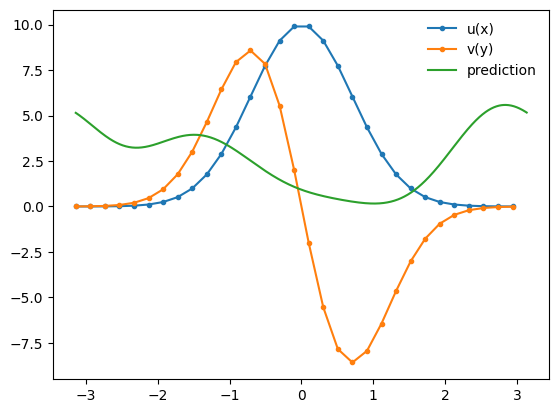

In [5]:
x_i, u_i, y_i, v_i = dataset[:] 
y_plot = xi.reshape(n_observations, -1, y_dim)
u_plot = u(y_plot)
v_pred = model(x_i, u_i, y_plot).squeeze()

plt.plot(x_i.squeeze(), u_i.squeeze(), marker=".", label="u(x)")
plt.plot(y_i.squeeze(), v_i.squeeze(), marker=".", label="v(y)")
plt.plot(y_plot.squeeze(), v_pred.squeeze().detach(), label="prediction")
plt.legend(frameon=False)

## Training

In [6]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
trainer = Trainer(model, device=device, optimizer=optimizer)

In [7]:
trainer.fit(dataset, epochs=30000)

Model parameters: 16
Device: cpu
Epoch 30000:  loss/train = 1.8321e-01  (0.000 s/epoch)


In [8]:
# compute prediction and reshape
x_i, u_i, y_i, v_i = dataset[:] 
y_plot = xi.reshape(n_observations, -1, y_dim)
u_plot = u(y_plot)

v_pred = model(x_i, u_i, y_plot).squeeze()

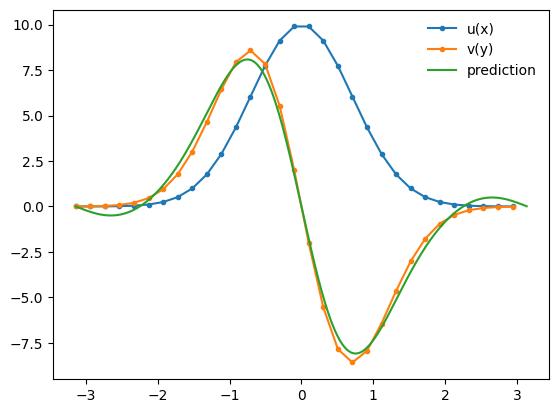

In [9]:
plt.plot(x_i.squeeze(), u_i.squeeze(), marker=".", label="u(x)")
plt.plot(y_i.squeeze(), v_i.squeeze(), marker=".", label="v(y)")
plt.plot(y_plot.squeeze(), v_pred.squeeze().detach(), label="prediction")
plt.legend(frameon=False)

### Changing the dimensionality of $u$

The FourierLayer allows you to change the number of evaluation points of $y$ for each forward pass. In the same way the dimensionality of parameter $u$ can also be changed. In the case of $u$ being larger than what was specified during initialization, the Fourier Layer removes the high frequencies. In case $u$ is smaller, zero-values large fequencies are added.

In [10]:
# compute prediction and reshape
x_i, u_i, y_i, v_i = dataset[:] 
y_plot = xi.reshape(n_observations, -1, y_dim)
u_plot = u(y_plot)

v_pred = model(x_i, u_plot, y_plot).squeeze()

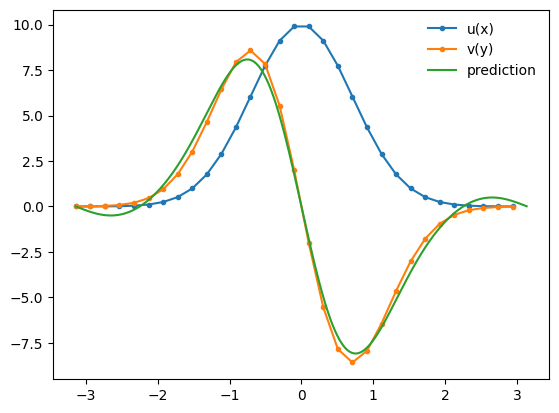

In [11]:
plt.plot(x_i.squeeze(), u_i.squeeze(), marker=".", label="u(x)")
plt.plot(y_i.squeeze(), v_i.squeeze(), marker=".", label="v(y)")
plt.plot(y_plot.squeeze(), v_pred.squeeze().detach(), label="prediction")
plt.legend(frameon=False)

## Reducing the number of modes

In [12]:
modes = [10, 4, 3]

Model parameters: 6
Device: cpu
Epoch 7163:  loss/train = 9.9918e-06  (0.000 s/epoch)
Model parameters: 3
Device: cpu
Epoch 10000:  loss/train = 1.6783e+00  (0.000 s/epoch)
Model parameters: 2
Device: cpu
Epoch 10000:  loss/train = 1.0294e+01  (0.000 s/epoch)


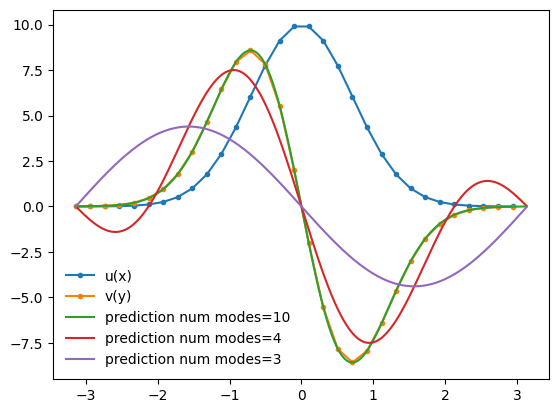

In [13]:
# plot ground truth
fig, ax = plt.subplots(1, 1)
ax.plot(x_i.squeeze(), u_i.squeeze(), marker=".", label="u(x)")
ax.plot(y_i.squeeze(), v_i.squeeze(), marker=".", label="v(y)")

for mode in modes:

    # define model with reduced number of modes
    model = FourierLayer(dataset.shapes, num_modes=(mode,))

    # train model
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    trainer = Trainer(model, device=device, optimizer=optimizer)
    trainer.fit(dataset, epochs=10000)

    # evaluate output
    u_plot = u(y_plot)
    v_pred1 = model(x_i, u_i, y_plot).squeeze()

    # plot results

    ax.plot(y_plot.squeeze(), v_pred1.squeeze().detach(), label=f"prediction num modes={mode}")
    ax.legend(frameon=False)


## Visualize the Fourier transformed functions

Text(0.5, 0, 'Img(v-fourier)')

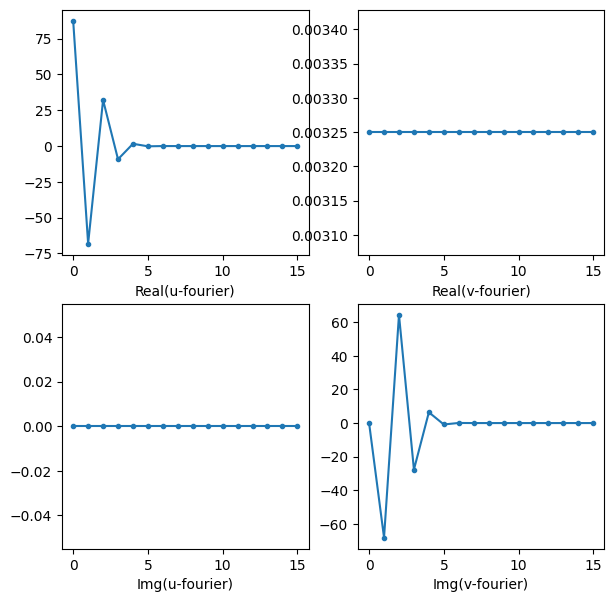

In [14]:
# Fourier transform of input and target function
u_fourier = torch.fft.rfft(u_i, dim=1)
v_fourier = torch.fft.rfft(v_i, dim=1)

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=[7, 7])

frequencies = range(0, len(u_fourier.squeeze()), 1)
ax1.plot(frequencies, u_fourier.squeeze().real, marker=".", label="u(x)")
ax1.set_xlabel("Real(u-fourier)")

ax3.plot(frequencies, u_fourier.squeeze().imag, marker=".", label="u(x)")
ax3.set_xlabel("Img(u-fourier)")

ax2.plot(frequencies, v_fourier.squeeze().real, marker=".", label="v(x)")
ax2.set_xlabel("Real(v-fourier)")

ax4.plot(frequencies, v_fourier.squeeze().imag, marker=".", label="v(x)")
ax4.set_xlabel("Img(v-fourier)")

## 2D Dataset

In [15]:
def multivariate_normal_2d(input_tensor: torch.Tensor, loc: int = 0., scale: float = 1.) -> torch.Tensor:
    """ Multivariate normal 2 dimensional distribution.

    Args:
        input_tensor: input with shape = (num_evaluations, 2)
        loc: Mean of normal dist
        scale: standard deviation of normal dist
    Returns:
        Tensor with shape = (num_evaluations)
    """

    distribution = MultivariateNormal(torch.ones(2) * loc, scale * torch.eye(2))
    value = torch.exp(distribution.log_prob(input_tensor))
    return value

def double_multivariate_normal_2d(input_tensor: torch.Tensor) -> torch.Tensor:
    """ Two Multivariate normal distributions with mean values at:
        * loc1 = (1, 1)
        # loc2 = (-1, -1)
    And standard deviation: 0.5

    Args:
        input_tensor: input with shape = (num_evaluations, 2)
    Returns:
        Tensor with shape = (num_evaluations)
    """

    #return input_tensor[:, 1] * input_tensor[:, 0] / 20
    return multivariate_normal_2d(input_tensor, 1, 0.5) + multivariate_normal_2d(input_tensor, -1, 0.5)

In [16]:

# define grid and flatten
N =51
x = torch.arange(-N/2, N/2) / N * 6
y = torch.arange(-N/2, N/2) / N * 6
xx, yy = torch.meshgrid(x, y)
input_tensor = torch.stack([xx.flatten(), yy.flatten()], axis=1)

# evaluate on grid
u = multivariate_normal_2d(input_tensor)
v = double_multivariate_normal_2d(input_tensor)

# reshape into grid
u_reshaped = u.reshape(N, N)
v_reshaped = v.reshape(N, N)

/Users/michelluchmann/Projects/Continuity/continuity/venv/lib/python3.11/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/TensorShape.cpp:3527.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


In [17]:
# define finer grid
N2 = 1000
x_fine = torch.arange(-N2/2, N2/2) / N2 * 6
y_fine = torch.arange(-N2/2, N2/2) / N2 * 6
xx_fine, yy_fine = torch.meshgrid(x_fine, y_fine)
input_tensor_fine = torch.stack([xx_fine.flatten(), yy_fine.flatten()], axis=1)

# evaluate on grid
u_fine = multivariate_normal_2d(input_tensor_fine).reshape(N2, N2)
v_fine = double_multivariate_normal_2d(input_tensor_fine).reshape(N2, N2)

# reshape into grid
u_reshaped_fine = u_fine.reshape(1, -1, 1)
v_reshaped_fine = v_fine.reshape(1, -1, 1)
x_reshaped_fine = torch.stack([xx_fine.flatten(), yy_fine.flatten()], axis=-1).unsqueeze(0)

Text(0.5, 1.0, 'Target function v(x) fine resolution')

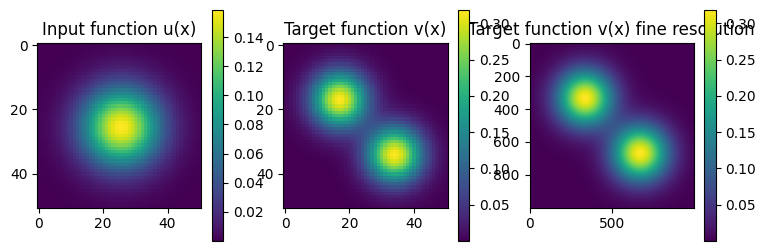

In [18]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=[9, 3])

img = ax1.imshow(u_reshaped)
fig.colorbar(img)
ax1.set_title("Input function u(x)")

img = ax2.imshow(v_reshaped)
fig.colorbar(img)
ax2.set_title("Target function v(x)")

img = ax3.imshow(v_reshaped_fine.reshape(N2, N2))
fig.colorbar(img)
ax3.set_title("Target function v(x) fine resolution")


In [19]:
x_reshaped = torch.stack([xx.flatten(), yy.flatten()], axis=-1).unsqueeze(0)
u_reshaped = u.reshape(1, -1, 1)
v_reshaped = v.reshape(1, -1, 1)

In [20]:
dataset_2d = OperatorDataset(
    x_reshaped,
    u_reshaped,
    x_reshaped,
    v_reshaped,
)

shapes = dataset_2d.shapes
data_loader_2d = DataLoader(dataset_2d)

In [21]:
model = FourierLayer(shapes=shapes)

In [22]:
x_i, u_i, y_i, v_i = dataset_2d[:]
v_pred_before = model(x_i, u_i, y_i)

batch_idx = 0
u_i_reshaped = u_i[batch_idx].reshape(N, N)
v_i_reshaped = v_i[batch_idx].reshape(N, N)
v_pred_reshaped = v_pred_before[batch_idx].reshape(N, N)

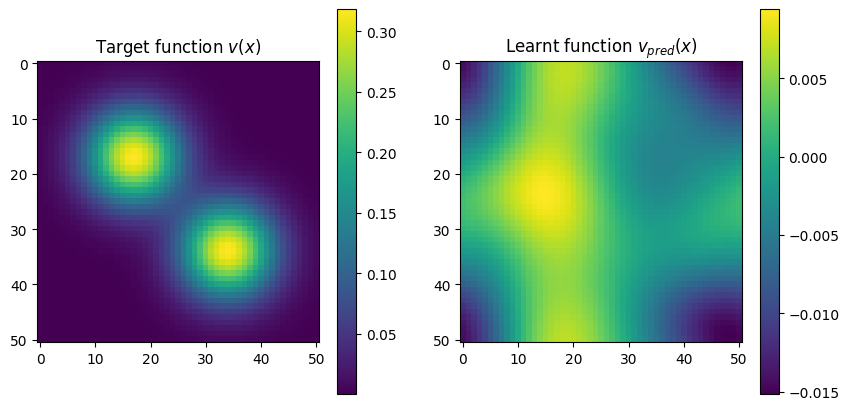

In [23]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=[10, 5])

img = ax1.imshow(v_i_reshaped.detach())
ax1.set_title(r'Target function $v(x)$')
fig.colorbar(img)

img2 = ax2.imshow(v_pred_reshaped.detach())
ax2.set_title(r'Learnt function $v_{pred}(x)$')
fig.colorbar(img2)

In [24]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
trainer = Trainer(model, device=device, optimizer=optimizer)

In [25]:
trainer.fit(dataset_2d, epochs=10000)

Model parameters: 1326
Device: cpu
Epoch 10000:  loss/train = 5.0507e-05  (0.000 s/epoch)


In [26]:
# evaluate prediction
y_plot = x_reshaped_fine
v_pred = model(x_i, u_reshaped, y_plot)
v_pred_reshaped = v_pred[batch_idx].reshape(N2, N2)

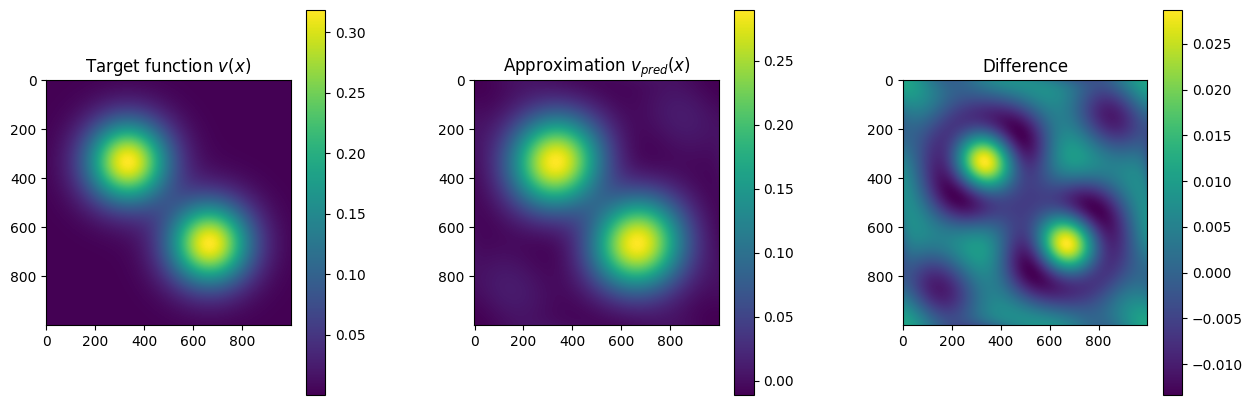

In [27]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=[15, 5], )

img = ax1.imshow(v_reshaped_fine.detach().reshape(N2, N2))
fig.colorbar(img)
ax1.set_title(r"Target function $v(x)$")

img2 = ax2.imshow(v_pred_reshaped.detach().reshape(N2, N2))
fig.colorbar(img2)
ax2.set_title(r"Approximation $v_{pred}(x)$")

img3 = ax3.imshow(v_reshaped_fine.detach().reshape(N2, N2) - v_pred_reshaped.detach())
fig.colorbar(img3)
ax3.set_title("Difference")

fig.subplots_adjust(wspace=0.4)

## Reducing the number of modes in 2d example

Test if we can reduce the number of modes per dimension independent of each other

In [28]:
model = FourierLayer(shapes=dataset_2d.shapes, num_modes=(4, 14))

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
trainer = Trainer(model, device=device, optimizer=optimizer)

In [29]:
trainer.fit(dataset_2d, epochs=20000)

Model parameters: 32
Device: cpu
Epoch 20000:  loss/train = 4.8069e-04  (0.000 s/epoch)


In [30]:
# evaluate prediction
y_plot = x_reshaped_fine
v_pred = model(x_i, u_reshaped, y_plot)
v_pred_reshaped = v_pred[batch_idx].reshape(N2, N2)

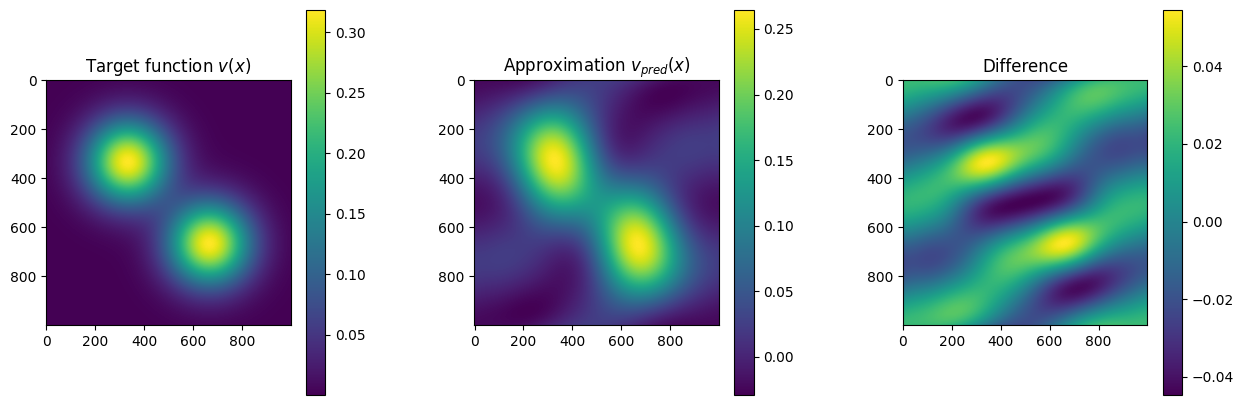

In [31]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=[15, 5], )

img = ax1.imshow(v_reshaped_fine.detach().reshape(N2, N2))
fig.colorbar(img)
ax1.set_title(r"Target function $v(x)$")

img2 = ax2.imshow(v_pred_reshaped.detach().reshape(N2, N2))
fig.colorbar(img2)
ax2.set_title(r"Approximation $v_{pred}(x)$")

img3 = ax3.imshow(v_reshaped_fine.detach().reshape(N2, N2) - v_pred_reshaped.detach())
fig.colorbar(img3)
ax3.set_title("Difference")

fig.subplots_adjust(wspace=0.4)

Text(0.5, 0, 'Projected on dim=1')

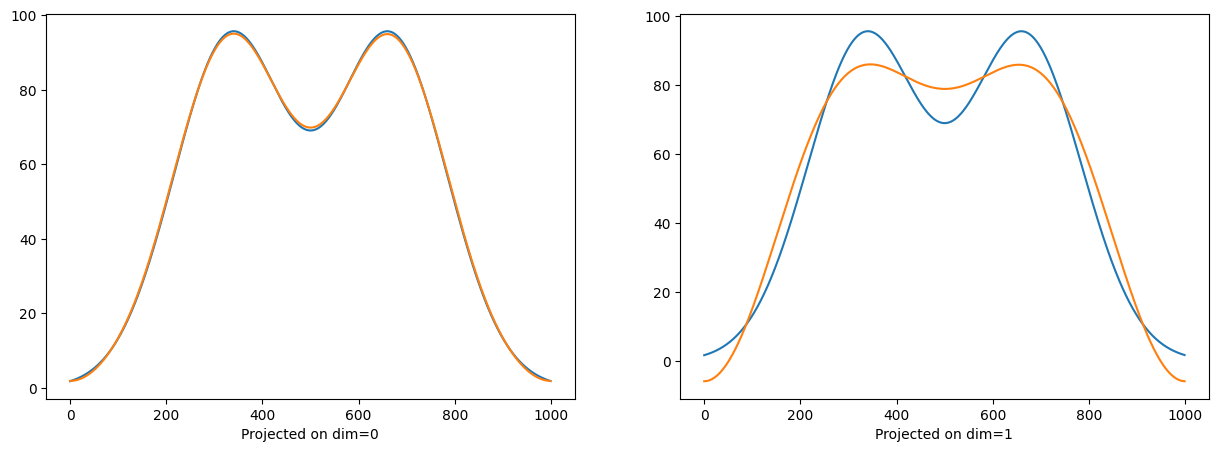

In [32]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=[15, 5], )

ax1.plot(v_reshaped_fine.detach().reshape(N2, N2).sum(axis=0))
ax1.plot(v_pred_reshaped.detach().reshape(N2, N2).sum(axis=0))
ax1.set_xlabel("Projected on dim=0")

ax2.plot(v_reshaped_fine.detach().reshape(N2, N2).sum(axis=1))
ax2.plot(v_pred_reshaped.detach().reshape(N2, N2).sum(axis=1))
ax2.set_xlabel("Projected on dim=1")

## 1d to 2d

Let's test if we can define a Fourier Operator acting on a 1d input function and outputing a 2d function.

```
u.dim = 1
v.dim = 2
```


In [33]:
# define grid and flatten
N = 50
x = torch.arange(-N/2, N/2) / N * torch.pi *1.5
y = torch.arange(-N/2, N/2) / N * torch.pi *1.5

N2 = 1000
y_high_resolution = torch.arange(-N2/2, N2/2) / N2 * torch.pi * 1.5

def function_2d(x):
    y1 = torch.sin(x) + torch.sin(x*2) * 0.2
    y2 = torch.cos(x) + torch.sin(x*3) * 3
    return torch.stack([y1, y2], axis=1)

def function_1d(x):
    return torch.sin(x) + torch.sin(x*2) * 0.5

# evaluate on grid
u = lambda x: function_1d(x)
v = lambda x: function_2d(x)

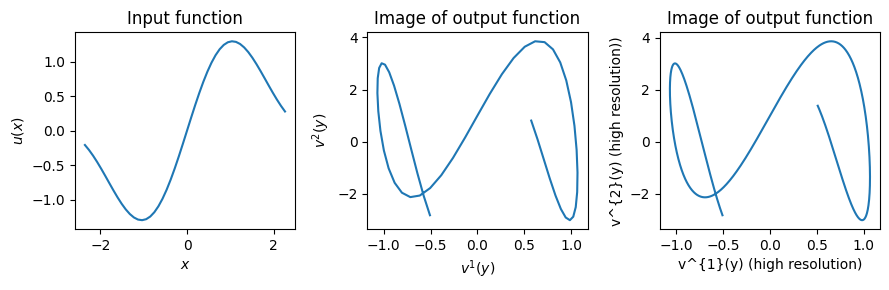

In [34]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(9, 3))

ax1.plot(x, u(x))
ax1.set_title('Input function')
ax1.set_xlabel("$x$")
ax1.set_ylabel("$u(x)$")

ax2.plot(v(y)[:, 0], v(y)[:, 1])
ax2.set_title('Image of output function')
ax2.set_xlabel("$v^{1}(y)$")
ax2.set_ylabel("$v^{2}(y)$")

ax3.plot(v(y_high_resolution)[:, 0], v(y_high_resolution)[:, 1])
ax3.set_title('Image of output function')
ax3.set_xlabel("v^{1}(y) (high resolution)")
ax3.set_ylabel("v^{2}(y) (high resolution))")

fig.tight_layout()

In [35]:
n_observations = 1
u_dim = 1
x_dim = y_dim = 1
v_dim = 2
num_sensors = N
num_evaluations = N
dataset = OperatorDataset(
    x=x.reshape(n_observations, num_sensors, x_dim),
    u=u(x).reshape(n_observations, num_sensors, u_dim),
    y=y.reshape(n_observations, num_evaluations, y_dim),
    v=v(y).reshape(n_observations, num_evaluations, v_dim)
)

In [36]:
dataset.shapes

DatasetShapes(num_observations=1, x=TensorShape(num=50, dim=1), u=TensorShape(num=50, dim=1), y=TensorShape(num=50, dim=1), v=TensorShape(num=50, dim=2))

In [37]:
model = FourierLayer(dataset.shapes)

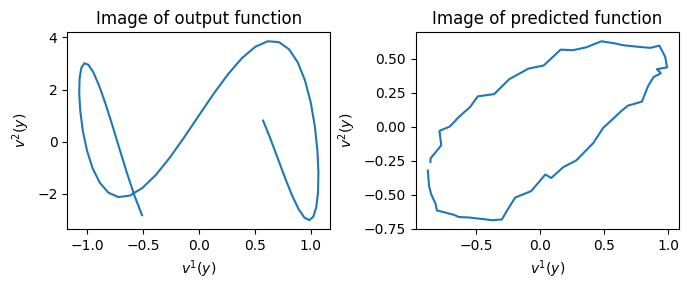

In [38]:
xi, ui, yi, vi = dataset[:]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(7, 3))

v_pred = model(xi, ui, yi).squeeze().detach()

ax1.plot(v(y)[:, 0], v(y)[:, 1])
ax1.set_title('Image of output function')
ax1.set_xlabel("$v^{1}(y)$")
ax1.set_ylabel("$v^{2}(y)$")


ax2.plot(v_pred[:, 0], v_pred[:, 1])
ax2.set_title('Image of predicted function')
ax2.set_xlabel("$v^{1}(y)$")
ax2.set_ylabel("$v^{2}(y)$")

fig.tight_layout()

In [39]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
trainer = Trainer(model, device=device, optimizer=optimizer)

In [40]:
trainer.fit(dataset, epochs=200000)

Model parameters: 52
Device: cpu
Epoch 64667:  loss/train = 9.9977e-06  (0.000 s/epoch)


In [41]:
xi, ui, yi, vi = dataset[:]
y_high_resolution_reshaped = y_high_resolution.reshape(1, -1, 1)

In [42]:
v_pred = model(xi, ui, y_high_resolution_reshaped)


Text(0, 0.5, '$v^{2}(y)$')

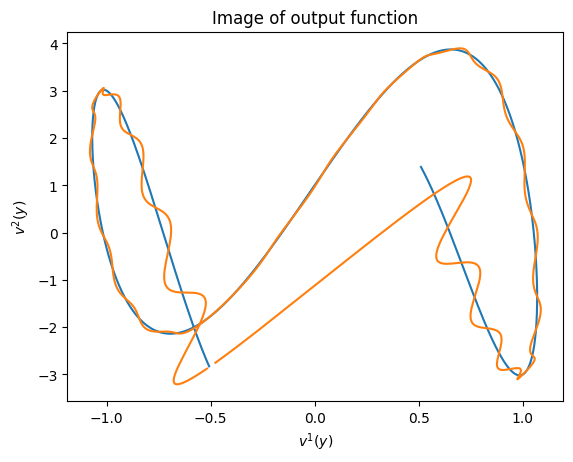

In [43]:
fig, ax = plt.subplots(1, 1)

ax.plot(v(y_high_resolution)[:, 0], v(y_high_resolution)[:, 1])
ax.plot(v_pred.squeeze()[:, 0].detach(), v_pred.squeeze()[:, 1].detach())
ax.set_title('Image of output function')
ax.set_xlabel("$v^{1}(y)$")
ax.set_ylabel("$v^{2}(y)$")
